In [1]:
from qiskit import Aer
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.execute import execute as qexecute
import pennylane as qml
import pennylane.numpy as np

In [2]:
qasm_simulator = Aer.get_backend('qasm_simulator')

## Target circuit: Trotter simulation of n-qubit 1D transverse Ising model

In [3]:
def make_target(num_qubits, h, dt, num_steps):
    circuit = QuantumCircuit(num_qubits)
    
    for step in range(num_steps):
        for iq in range(num_qubits):
            circuit.cx(iq, (iq + 1) % num_qubits)
            circuit.rz(-2. * dt, (iq + 1) % num_qubits)
            circuit.cx(iq, (iq + 1) % num_qubits)
            circuit.rx(2. * dt * h, (iq + 1) % num_qubits)
            
    return circuit

## Ansatz: Rx-Rz-CZ

In [4]:
def make_ansatz(num_qubits, num_blocks):
    circuit = QuantumCircuit(num_qubits)
    params = ParameterVector('theta')

    ip = 0
    for ib in range(num_blocks):
        params.resize(len(params) + num_qubits)
        for iq in range(num_qubits):
            circuit.rx(params[-num_qubits + iq], iq)
            
        # possibly this block can be under the if statement below
        params.resize(len(params) + num_qubits)
        for iq in range(num_qubits):
            circuit.rz(params[-num_qubits + iq], iq)

        if ib != num_blocks - 1:
            for iq in range(num_qubits - 1):
                circuit.cz(iq, iq + 1)
        
    return circuit, params

## Gradient computation for all parameters with a single circuit

In [5]:
def gradient(circuit, params, values, backend, backend_options=None, shots=8192):
    # Circuit width = original width x (#params x 2)
    grad_circuit = QuantumCircuit(circuit.num_qubits * len(params) * 2)

    # Make a sub-circuit for each parameter for each shift direction
    for ip, parameter in enumerate(params):
        for it, shift in enumerate([np.pi / 2., -np.pi / 2.]):
            qc = circuit.copy()
            param_map = dict(zip(params, values))
            param_map[parameter] += shift
            qc.assign_parameters(param_map, inplace=True)
            
            # Compose the sub-circuit into grad_circuit
            qlow = circuit.num_qubits * (2 * ip + it)
            qhigh = qlow + circuit.num_qubits
            grad_circuit.compose(qc, qubits=list(range(qlow, qhigh)), inplace=True)
            
    grad_circuit.measure_all()

    # Do the measurement
    if backend.provider() is Aer:
        # This is a simulator; do all shots at once
        job = qexecute(grad_circuit, backend, backend_options=backend_options, shots=shots)
        counts = job.result().get_counts(grad_circuit)
    else:
        # Running on IBMQ; need to split jobs into chunks of 8192 shots
        ishot = 0
        counts = dict()
        while ishot <= shots:
            sh = min(8192, shots - ishot)
            job = qexecute(grad_circuit, backend, backend_options=backend_options, shots=sh)
            counts.update(job.result().get_counts(grad_circuit))
            ishot += sh
    
    # Compute the gradients
    gradient = np.empty_like(values)

    mask = (1 << circuit.num_qubits) - 1
    for ip in range(len(params)):
        upmask = mask << (circuit.num_qubits * 2 * ip)
        downmask = mask << (circuit.num_qubits * (2 * ip + 1))
        
        for key, value in counts.items():
            if int(key, 2) & upmask == 0:
                gradient[ip] += value
            if int(key, 2) & downmask == 0:
                gradient[ip] -= value
               
        # dL/dp = 0.5 * (P(p + pi/2) - P(p - pi/2))
        gradient[ip] *= 0.5 / shots
        
    return -gradient # sign for cost being -prob

## Set up the problem and ansatz parameters

In [6]:
num_qubits = 2 # size of the 1D Ising model  
h = 3.
dt = 0.01 
num_steps = 2
num_blocks = 2

learning_iterations = 100

## Define the quantum circuits

In [7]:
target = make_target(num_qubits, h, dt, num_steps)
ansatz, params = make_ansatz(num_qubits, num_blocks)
circuit = target + ansatz

## Optimize

In [8]:
theta = np.ones(len(params), dtype=float)

optimizer = qml.AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.999, eps=1.e-8)

for it in range(learning_iterations):
    grad = gradient(circuit, params, theta, qasm_simulator, backend_options={'method': 'matrix_product_state', 'max_memory_mb': 50000})
    if it % 10 == 0:
        print('iteration', it, 'grad', grad)
    theta = optimizer.apply_grad(grad, theta)

theta_optim_qasm = np.array(theta)

iteration 0 grad [ 0.05505371  0.05657959 -0.21936035 -0.22174072  0.02709961  0.02478027
  0.0022583  -0.00665283]
iteration 10 grad [ 0.18934433  0.19672938 -0.18409262 -0.18744954  0.1474764   0.14704965
 -0.00121251  0.00316728]
iteration 20 grad [ 0.22476828  0.22385219 -0.03615156 -0.02717929  0.12053036  0.10655517
  0.00550275 -0.00232832]
iteration 30 grad [-0.02398173 -0.01745188 -0.00020643  0.00125876 -0.12638854 -0.13535951
  0.00159934  0.00023425]
iteration 40 grad [-0.07115094 -0.07084616 -0.00545729 -0.00228293 -0.04271865 -0.02422673
 -0.00023074 -0.00019346]
iteration 50 grad [-0.01945873 -0.02318146  0.00302573  0.00345364  0.049553    0.05821972
 -0.00078133 -0.00086512]
iteration 60 grad [ 7.51358247e-03  4.15717499e-03 -8.73000854e-05 -2.69661075e-04
  7.31287968e-04 -5.55417703e-03  1.06525879e-05 -7.16924962e-05]
iteration 70 grad [ 0.0132501   0.01587435  0.00070608  0.00058479 -0.01696427 -0.01745265
 -0.00023403  0.0002334 ]
iteration 80 grad [-5.30294574e-0

## Optimization cross-check using Pennylane

In [9]:
qmldev = qml.device('default.qubit', wires=num_qubits)

wires = list(range(num_qubits))
qml_circuit = qml.from_qiskit(circuit)

@qml.qnode(qmldev)
def qnode(theta):
    parameter_binding = dict(zip(params, theta))
    qml_circuit(parameter_binding, wires=wires)

    return qml.probs(wires=wires)

def cost(theta):
    return -qnode(theta)[0]

In [10]:
losses = np.empty(learning_iterations, dtype=np.float)
theta = np.ones(len(params), dtype=np.float)

optimizer = qml.AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.999, eps=1.e-8)

for it in range(learning_iterations):
    # Compute the loss to just keep track - not necessary for gradient computation (unlike when using torch)
    losses[it] = cost(theta)

    # compute_grad() + apply_grad() is identical to step()
    g = optimizer.compute_grad(cost, theta)
    if it % 10 == 0:
        print('iteration', it, 'grad', g)
    theta = optimizer.apply_grad(g, theta)
    
theta_optim_pennylane = np.array(theta)

iteration 0 grad [ 0.05675113  0.05703323 -0.22047061 -0.2205702   0.02598069  0.02660586
  0.          0.        ]
iteration 10 grad [ 0.18859173  0.18888276 -0.18434802 -0.18488318  0.13671924  0.13814266
  0.          0.        ]
iteration 20 grad [ 2.26196753e-01  2.27321671e-01 -3.55372445e-02 -3.68728036e-02
  1.14680146e-01  1.18633958e-01  0.00000000e+00  5.55111512e-17]
iteration 30 grad [-1.46582422e-02 -1.40231197e-02  2.51313966e-03  2.58450074e-03
 -1.26661311e-01 -1.25279033e-01  1.11022302e-16 -1.11022302e-16]
iteration 40 grad [-7.36730619e-02 -7.44469142e-02 -4.01667930e-03 -4.79520328e-03
 -3.81715104e-02 -4.24442947e-02 -1.11022302e-16  0.00000000e+00]
iteration 50 grad [-0.02260427 -0.02278482  0.00412005  0.00400188  0.05982121  0.05929655
  0.          0.        ]
iteration 60 grad [6.85456707e-03 7.35129112e-03 2.39020771e-05 6.62242113e-07
 4.61884881e-04 3.36425749e-03 0.00000000e+00 0.00000000e+00]
iteration 70 grad [ 1.06463840e-02  1.03077329e-02  7.16228904

In [11]:
print(theta_optim_qasm)
print(theta_optim_pennylane)

[-0.12038654 -0.12448409  1.43175375  1.41892455 -0.01455626 -0.0097026
  0.85606988  1.18758402]
[-0.12370448 -0.12354329  1.42673055  1.4289636  -0.00989293 -0.01271578
  1.          1.        ]


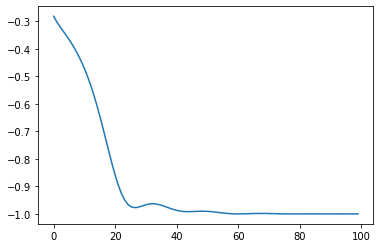

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.arange(learning_iterations), losses)